# 1. Imports en Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge


# hier pivot ik de tabel en laat ik alle strings weg in elke kolom.
nut = pd.read_csv('/data/foodboost/nutritions.csv')
nut_pivot= nut.pivot_table(index='recipe', columns="nutrition", values="value", aggfunc="sum")
nut_pivot['eiwit'] = nut_pivot['eiwit'].str.replace('g', '').astype(float)
nut_pivot['vet'] = nut_pivot['vet'].str.replace('g', '').astype(float)
nut_pivot['koolhydraten'] = nut_pivot['koolhydraten'].str.replace('g', '').astype(float)
nut_pivot['energie'] = nut_pivot['energie'].str.replace('kcal', '').astype(float)
nut_pivot['natrium'] = nut_pivot['natrium'].str.replace('mg', '').astype(float)
nut_pivot['vezels'] = nut_pivot['vezels'].str.replace('g', '').astype(float)
nut_pivot['waarvan suikers'] = nut_pivot['waarvan suikers'].str.replace('g', '').astype(float)
nut_pivot['waarvan verzadigd'] = nut_pivot['waarvan verzadigd'].str.replace('g', '').astype(float)

# hier replace ik alle na waardes met 0
nut_pivot= nut_pivot.fillna(0) 

# hier group ik alle tags van elke recept in een rij
tags = pd.read_csv('/data/foodboost/tags.csv')
tags['tags'] = tags[['recipe', 'tag']].groupby(['recipe'])['tag'].transform(lambda x: ','.join(x))
tags_together = tags[['recipe', 'tags']]
tags_together.drop_duplicates(inplace=True, ignore_index=True)
tags_together

# hier merge ik tags_together met nut_pivot op basis van 'recipe' kolom
tags_together = tags.groupby('recipe')['tags'].apply(lambda x: ','.join(x)).reset_index()
nut_pivot = pd.merge(nut_pivot, tags_together, on='recipe')

nut_pivot

/tmp/ipykernel_27222/3945581577.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_together.drop_duplicates(inplace=True, ignore_index=True)


,recipe,eiwit,energie,koolhydraten,natrium,vet,vezels,waarvan suikers,waarvan verzadigd,tags
0,Andijviestamppot met gebakken salami,25.0,630.0,36.0,1875.0,41.0,7.0,0.0,17.0,"snel,hollands,stamppot,hoofdgerecht,wat eten w..."
1,Bietensoep met selderijroom,3.0,160.0,11.0,1160.0,11.0,5.0,0.0,5.0,"vooraf te maken,soep,voorgerecht,kerst,koken,v..."
2,Libanese wraps met appel-koolsalade,21.0,440.0,45.0,440.0,18.0,9.0,0.0,3.0,"snel,wrap,hoofdgerecht,wat eten we vandaag,sne..."
3,Plaattaart met gegrilde groenten en witte kaas,16.0,550.0,38.0,760.0,35.0,8.0,11.0,16.0,"zonder vlees/vis,budget,oven,hoofdgerecht,wat ..."
4,Sticky cauliflower (gegrilde bloemkoolroosjes...,8.0,235.0,16.0,800.0,14.0,6.0,0.0,2.0,"veganistisch,borrelhapje,tussendoortje,bijgere..."
...,...,...,...,...,...,...,...,...,...,...
8700,Zweedse gehaktballetjes met room,33.0,640.0,26.0,520.0,45.0,2.0,0.0,22.0,"scandinavisch,kindergerecht,bijgerecht,bakken,..."
8701,Zweedse vegaballetjes met aardappel &amp; broc...,38.0,770.0,76.0,1320.0,31.0,17.0,0.0,10.0,"vegetarisch,hoofdgerecht,wat eten we vandaag,b..."
8702,Zwitserse kaasfondue,56.0,850.0,7.0,920.0,63.0,0.0,5.0,38.0,"zonder vlees/vis,hoofdgerecht,fondue,sinterkla..."
8703,Îles flottantes,10.0,290.0,49.0,125.0,6.0,0.0,0.0,3.0,"frans,nagerecht,kerst,pasen,pocheren,frans,nag..."


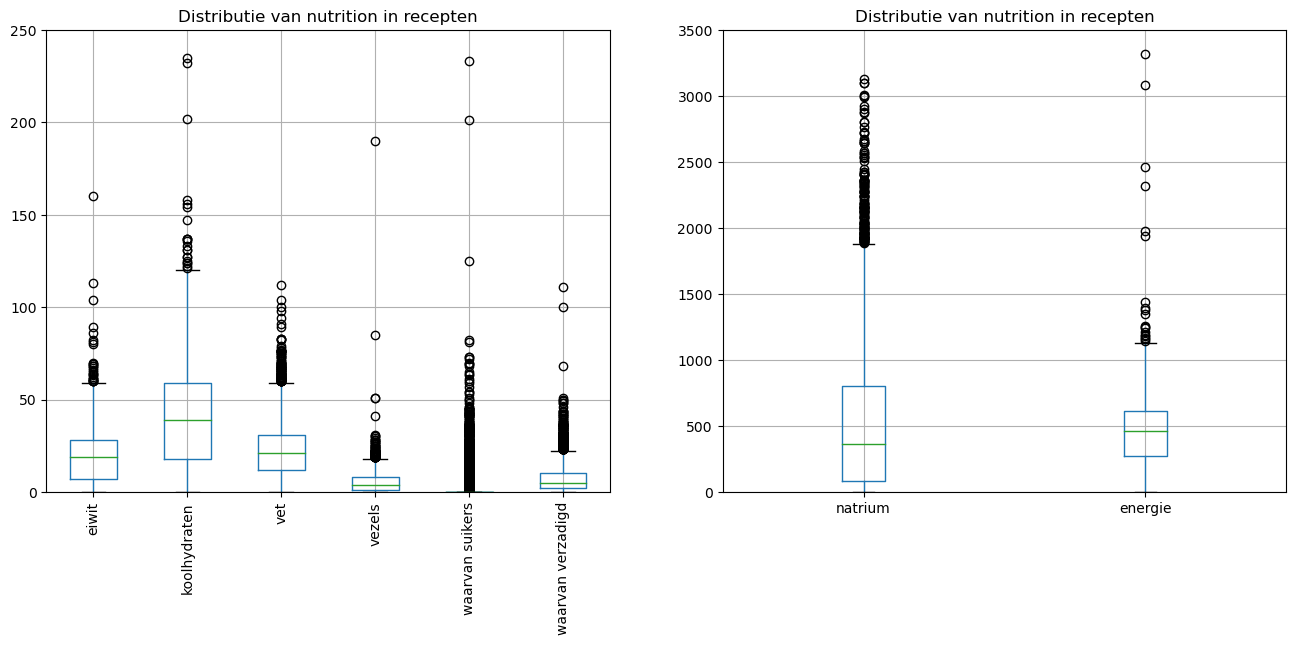

In [2]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

nutritions1 = nut_pivot[['eiwit', 'koolhydraten', 'vet', 'vezels', 'waarvan suikers', 'waarvan verzadigd']]
nutritions1.boxplot(ax=axs[0])
axs[0].set_ylim(0, 250)
axs[0].set_title('Distributie van nutrition in recepten')
axs[0].tick_params(axis='x', labelrotation=90)  # rotate x-axis labels

nutritions2 = nut_pivot[['natrium', 'energie']]
nutritions2.boxplot(ax=axs[1])
axs[1].set_ylim(0, 3500)
axs[1].set_title('Distributie van nutrition in recepten')

plt.show()


In [7]:
# oude methode 17-2-23   
# def is_gezond(recept):
#    return (recept['energie'] < 500 and 
#            recept['waarvan suikers'] < 10 and 
#            recept['waarvan verzadigd'] < 10) or \
#           (recept['eiwit'] >= 10 and 
#            recept['vezels'] >= 3 and 
#            recept['natrium'] < 500) or \
#           (recept['koolhydraten'] < 50 and 
#            recept['vet'] < 4)

recepten = nut_pivot
# hier defineer ik wanneer een recept gezond is 
def get_gezonde_score(recept):
    score = 1
    
    # Energie criteria
    if recept['energie'] < 500 and recept['waarvan suikers'] < 10 and recept['waarvan verzadigd'] < 25:
        score += 2
    if recept['energie'] < 750 and recept['koolhydraten'] < 65 and recept['vezels'] >= 5:
        score += 1
    if recept['energie'] < 1000 and recept['eiwit'] > 15 and recept['vezels'] >= 10:
        score += 1
    
    # Eiwit criteria
    if recept['eiwit'] >= 10 and recept['waarvan suikers'] < 30 and recept['vet'] < 40:
        score += 2
    if recept['eiwit'] >= 10 and recept['koolhydraten'] < 75 and recept['vezels'] >= 5:
        score += 1
    if recept['eiwit'] >= 10 and recept['vezels'] >= 5 and recept['natrium'] < 1500:
        score += 1
    
    # Koolhydraten criteria
    if recept['koolhydraten'] < 50 and recept['vet'] < 15:
        score += 1
        
    return score

recepten['gezonde_score'] = recepten.apply(get_gezonde_score, axis=1)

# de data splits op in een trainings- en een testset
train_data, test_data = train_test_split(recepten, test_size=0.2, random_state=42)
features = ['eiwit', 'vet', 'koolhydraten',] 
target = 'gezonde_score'  


# training RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10, min_samples_leaf=1, min_samples_split=20)
rf.fit(train_data[features], train_data[target])
# testset RandomForestRegressor
test_data['voorspelling_gezonde_score_rfr'] = rf.predict(test_data[features])


# training LinearRegression
lr = LinearRegression(fit_intercept=True, normalize=True)
lr.fit(train_data[features], train_data[target])
# testset LinearRegression
test_data['voorspelling_gezonde_score_lr'] = lr.predict(test_data[features])


# training Ridge
ridge = Ridge(alpha=1.0, fit_intercept=True, normalize=True)
ridge.fit(train_data[features], train_data[target])
# testset Ridge
test_data['voorspelling_gezonde_score_ridge'] = ridge.predict(test_data[features])


# de prestaties van het model evalueren met behulp van mean squared error
mse = mean_squared_error(test_data[target], test_data['voorspelling_gezonde_score_rfr'])
mse_lr = mean_squared_error(test_data[target], test_data['voorspelling_gezonde_score_lr'])
mse_ridge = mean_squared_error(test_data[target], test_data['voorspelling_gezonde_score_ridge'])

print(f"RandomForestRegressor   MSE: {mse}")
print(f"Linear regression       MSE: {mse_lr}")
print(f"Ridge                   MSE: {mse_ridge}")

recepten = recepten.assign(voorspelling_gezonde_score_rfr=rf.predict(recepten[features]).round(0))
recepten = recepten.assign(voorspelling_gezonde_score_lr=lr.predict(recepten[features]).round(0))
recepten = recepten.assign(voorspelling_gezonde_score_ridge=ridge.predict(recepten[features]).round(0))
recepten

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import ma

RandomForestRegressor   MSE: 1.4350337362193633
Linear regression       MSE: 3.088204926609484
Ridge                   MSE: 3.363637985634851


,recipe,eiwit,energie,koolhydraten,natrium,vet,vezels,waarvan suikers,waarvan verzadigd,tags,gezonde_score,voorspelling_gezonde_score_rfr,voorspelling_gezonde_score_lr,voorspelling_gezonde_score_ridge
0,Andijviestamppot met gebakken salami,25.0,630.0,36.0,1875.0,41.0,7.0,0.0,17.0,"snel,hollands,stamppot,hoofdgerecht,wat eten w...",3,4.0,4.0,4.0
1,Bietensoep met selderijroom,3.0,160.0,11.0,1160.0,11.0,5.0,0.0,5.0,"vooraf te maken,soep,voorgerecht,kerst,koken,v...",5,4.0,5.0,5.0
2,Libanese wraps met appel-koolsalade,21.0,440.0,45.0,440.0,18.0,9.0,0.0,3.0,"snel,wrap,hoofdgerecht,wat eten we vandaag,sne...",8,7.0,5.0,5.0
3,Plaattaart met gegrilde groenten en witte kaas,16.0,550.0,38.0,760.0,35.0,8.0,11.0,16.0,"zonder vlees/vis,budget,oven,hoofdgerecht,wat ...",6,5.0,4.0,4.0
4,Sticky cauliflower (gegrilde bloemkoolroosjes...,8.0,235.0,16.0,800.0,14.0,6.0,0.0,2.0,"veganistisch,borrelhapje,tussendoortje,bijgere...",5,4.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8700,Zweedse gehaktballetjes met room,33.0,640.0,26.0,520.0,45.0,2.0,0.0,22.0,"scandinavisch,kindergerecht,bijgerecht,bakken,...",1,2.0,4.0,5.0
8701,Zweedse vegaballetjes met aardappel &amp; broc...,38.0,770.0,76.0,1320.0,31.0,17.0,0.0,10.0,"vegetarisch,hoofdgerecht,wat eten we vandaag,b...",5,4.0,5.0,5.0
8702,Zwitserse kaasfondue,56.0,850.0,7.0,920.0,63.0,0.0,5.0,38.0,"zonder vlees/vis,hoofdgerecht,fondue,sinterkla...",1,1.0,5.0,5.0
8703,Îles flottantes,10.0,290.0,49.0,125.0,6.0,0.0,0.0,3.0,"frans,nagerecht,kerst,pasen,pocheren,frans,nag...",6,7.0,5.0,5.0


# 2. Predictive Analysis

In [ ]:
#tuning hyperparameters RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6]
}

rfr = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(train_data[features], train_data[target])

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best MSE: {-grid_search.best_score_}")

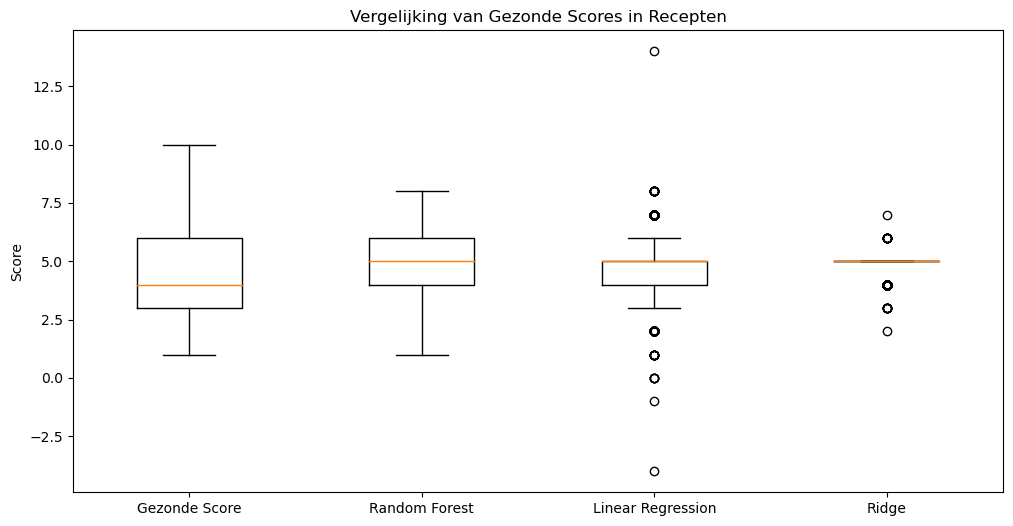

In [11]:
data = [recepten['gezonde_score'], recepten['voorspelling_gezonde_score_rfr'], 
        recepten['voorspelling_gezonde_score_lr'], recepten['voorspelling_gezonde_score_ridge']]

fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(data)
ax.set_xticklabels(['Gezonde Score', 'Random Forest', 
                    'Linear Regression', 'Ridge'])
ax.set_ylabel('Score')
ax.set_title('Vergelijking van Gezonde Scores in Recepten')
plt.show()

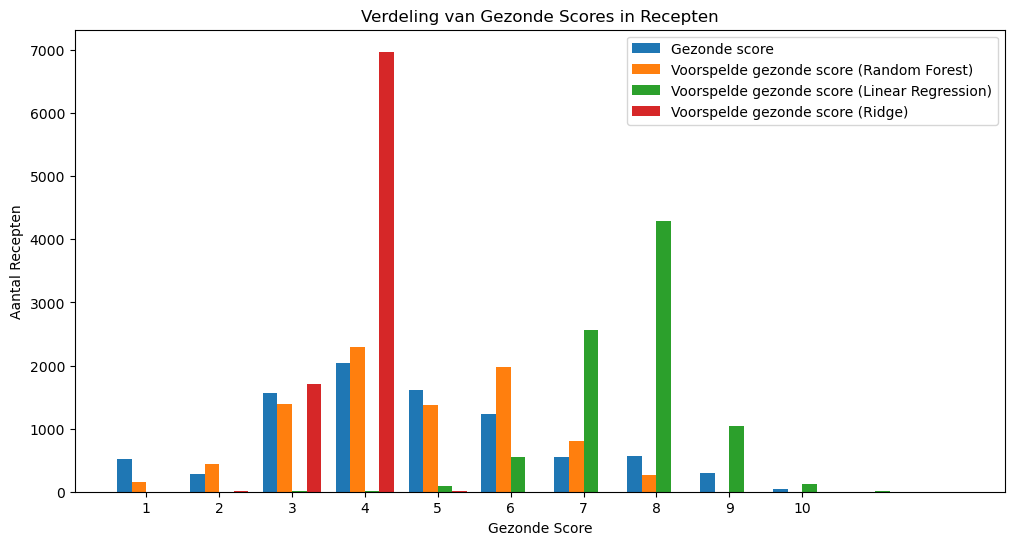

In [10]:
aantallen_gezond = recepten['gezonde_score'].value_counts().sort_index()
aantallen_voorspeld_rf = recepten['voorspelling_gezonde_score_rfr'].value_counts().sort_index()
aantallen_voorspeld_lr = recepten['voorspelling_gezonde_score_lr'].value_counts().sort_index()
aantallen_voorspeld_ridge = recepten['voorspelling_gezonde_score_ridge'].value_counts().sort_index()

x_gezond = np.arange(len(aantallen_gezond))
x_voorspeld_rf = np.arange(len(aantallen_voorspeld_rf))
x_voorspeld_lr = np.arange(len(aantallen_voorspeld_lr))
x_voorspeld_ridge = np.arange(len(aantallen_voorspeld_ridge))

breedte = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x_gezond - 1.5*breedte, aantallen_gezond, breedte, label='Gezonde score')
rects2 = ax.bar(x_voorspeld_rf - 0.5*breedte, aantallen_voorspeld_rf, breedte, label='Voorspelde gezonde score (Random Forest)')
rects3 = ax.bar(x_voorspeld_lr + 0.5*breedte, aantallen_voorspeld_lr, breedte, label='Voorspelde gezonde score (Linear Regression)')
rects4 = ax.bar(x_voorspeld_ridge + 1.5*breedte, aantallen_voorspeld_ridge, breedte, label='Voorspelde gezonde score (Ridge)')

ax.set_xlabel('Gezonde Score')
ax.set_ylabel('Aantal Recepten')
ax.set_title('Verdeling van Gezonde Scores in Recepten')
ax.set_xticks(x_gezond)
ax.set_xticklabels(range(1, len(aantallen_gezond)+1))
ax.legend()

plt.show()

#                                  Model keuze = RandomForest
Uit de resultaten van de drie modellen blijkt dat de MSE van het RandomForestRegressor-model lager is dan de MSE van het Lineaire regressiemodel en van de Ridge. Dit betekent dat het RandomForestRegressor-model beter presteert in het voorspellen van de gezonde score van de recepten dan het Lineaire regressiemodel en de Ridge. Daarom is het logisch om verder te gaan met het RandomForestRegressor-model in plaats van het Lineaire regressiemodel of Ridge.


# Verschillende keukens

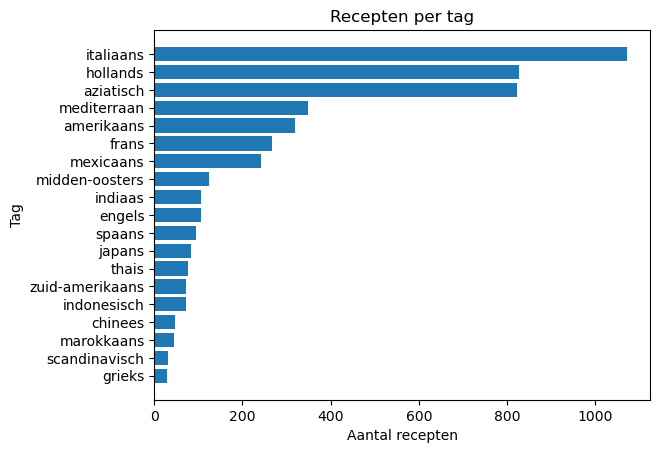

In [57]:
tags_to_count = ['amerikaans','aziatisch','chinees','engels','frans','grieks','hollands','indiaas','indonesisch','italiaans', 'japans','marokkaans','mediterraan', 'mexicaans', 'midden-oosters','scandinavisch','spaans','thais','zuid-amerikaans']
tag_counts = pd.Series([recepten['tags'].str.contains(tag).sum() for tag in tags_to_count], index=tags_to_count)

tag_counts = tag_counts.sort_values(ascending=True)

plt.barh(tag_counts.index, tag_counts.values)
plt.title('Recepten per tag')
plt.ylabel('Tag')
plt.xlabel('Aantal recepten')
plt.show()


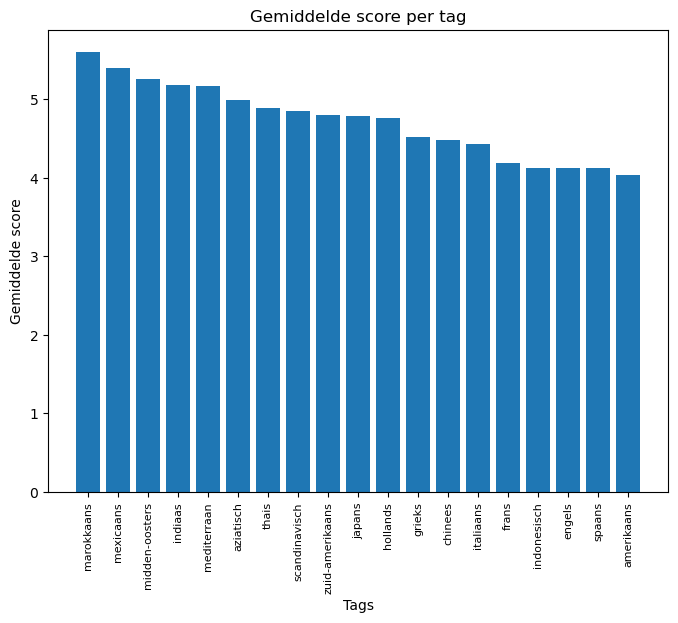

In [58]:
mean_scores = []
for tag in tags_to_count:
    mean_score = recepten[recepten['tags'].str.contains(tag)]['gezonde_score'].mean()
    mean_scores.append(mean_score)

tags_to_count, mean_scores = zip(*sorted(zip(tags_to_count, mean_scores), key=lambda x: x[1], reverse=True))


fig, ax = plt.subplots(figsize=(8,6))
ax.bar(tags_to_count, mean_scores)
ax.set_xlabel('Tags')
ax.set_ylabel('Gemiddelde score')
ax.set_title('Gemiddelde score per tag')
plt.xticks(rotation=90, fontsize=8)
plt.show()

# Visualisaties met voorspelling RandomForestRegressor

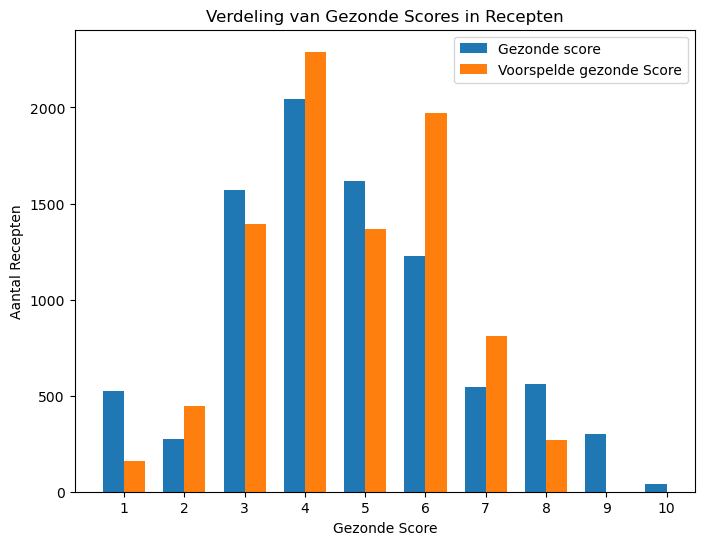

In [59]:
aantallen_gezond = recepten['gezonde_score'].value_counts().sort_index()
aantallen_voorspeld = recepten['voorspelling_gezonde_score_rfr'].value_counts().sort_index()
x_gezond = np.arange(len(aantallen_gezond))
x_voorspeld = np.arange(len(aantallen_voorspeld))
breedte = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x_gezond - breedte/2, aantallen_gezond, breedte, label='Gezonde score')
rects2 = ax.bar(x_voorspeld + breedte/2, aantallen_voorspeld, breedte, label='Voorspelde gezonde Score')

ax.set_xlabel('Gezonde Score')
ax.set_ylabel('Aantal Recepten')
ax.set_title('Verdeling van Gezonde Scores in Recepten')
ax.set_xticks(x_gezond)
ax.set_xticklabels(range(1, len(aantallen_gezond)+1))
ax.legend()

plt.show()

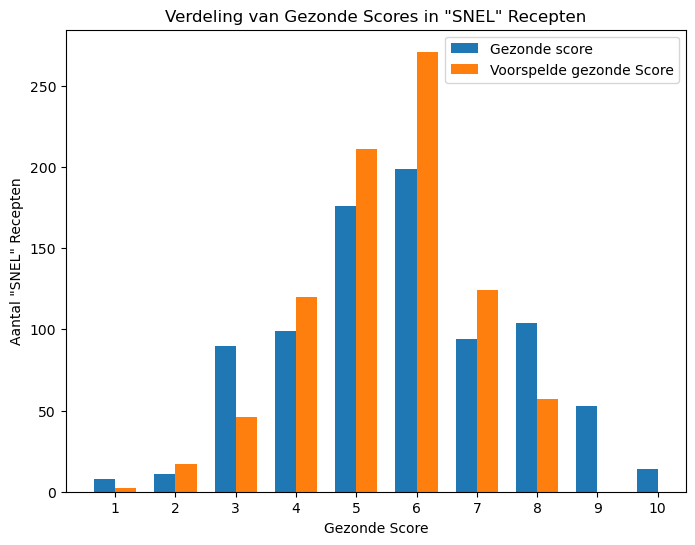

In [60]:
aantallen_gezond = recepten[recepten['tags'].str.contains('snel')]['gezonde_score'].value_counts().sort_index()
aantallen_voorspeld = recepten[recepten['tags'].str.contains('snel')]['voorspelling_gezonde_score_rfr'].value_counts().sort_index()                               
x_gezond = np.arange(len(aantallen_gezond))
x_voorspeld = np.arange(len(aantallen_voorspeld))
breedte = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x_gezond - breedte/2, aantallen_gezond, breedte, label='Gezonde score')
rects2 = ax.bar(x_voorspeld + breedte/2, aantallen_voorspeld, breedte, label='Voorspelde gezonde Score')

ax.set_xlabel('Gezonde Score')
ax.set_ylabel('Aantal "SNEL" Recepten')
ax.set_title('Verdeling van Gezonde Scores in "SNEL" Recepten')
ax.set_xticks(x_gezond)
ax.set_xticklabels(range(1, len(aantallen_gezond)+1))
ax.legend()

plt.show()
                               
                        
# algemeen denken mensen dat snelle recepten ongezond is. Maar dat valt toch wel tegen.